<a href="https://colab.research.google.com/github/dawit-melka/Amharic-Hate-speech-detection/blob/main/mBERT/Amharic_Hate_Speech_detection_models_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install the necessary packages**

In [ ]:
#installing the transformers package
!pip install transformers

In [ ]:
#installing the datasets package
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00


**Import the necessay libraries from the installed packages**

In [ ]:
#importing the datasets package
from datasets import Dataset
import datasets
#import load metric for model evaluation
from evaluate import load

In [ ]:
#import numpy and pandas for mathematical computation and data manipulation respectively
import numpy as np
import pandas as pd
#import drive package to connect this colab file with the drive where the data will be retrived from
from google.colab import drive
#import the pipeline of transformers
from transformers import pipeline
#import AutoTokenizer for tokenization purposes
from transformers import AutoTokenizer


In [ ]:
#import torch
import torch
#import Data loader from torch
from torch.utils.data import DataLoader
#import an optimizer
from torch.optim import AdamW
#import tqdm for a progress bar
from tqdm.auto import tqdm
#Load auto mode classifier from the pretrained model
from transformers import AutoModelForSequenceClassification

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#mount google drive to access the dataset directly from the drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Test the model with different dataset**

In [ ]:
def read_file(file_path):
    # Read with explicit handling of quotes and delimiters
    df = pd.read_csv(
        file_path,
        quotechar='"',
        skipinitialspace=True,
        on_bad_lines="skip",
        sep=","
    )
    # Check the structure of the loaded DataFrame
    print(f"First few rows:\n{df.head()}\n")
    print(f"Loaded {file_path} with shape: {df.shape}\n")
    print(f"Columns: {df.columns}\n\n")
    # Split the single column if needed
    if len(df.columns) == 1 and "Content,Label" in df.columns[0]:
        print(f"Splitting the single column...\n")
        df = df[df.columns[0]].str.split(",", n=1, expand=True)
        df.columns = ["Content", "Label"]
        print(f"After splitting:\n{df.head()}\n")
        print(f"Loaded {file_path} with shape: {df.shape}")
    elif len(df.columns) != 2:
        raise ValueError(f"Unexpected number of columns in {file_path}.")
    df['Content'] = df['Content'].str.strip()
    df['Label'] = df['Label'].str.strip()
    return df


In [ ]:
# Truncate or split long texts
def process_text(text, tokenizer, max_length=512):
    # Tokenize and check length
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # If tokens are too long, truncate
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
        text = tokenizer.decode(tokens)

    return text

In [ ]:
# Paths to files
train_path = '/content/drive/MyDrive/Hate speech dataset/AMHSDataTrain.csv'
test_path = '/content/drive/MyDrive/Hate speech dataset/AMHSDataTest.csv'

# Read datasets
train_df = read_file(train_path)
test_df = read_file(test_path)

# Combine datasets
combined_df = pd.concat([train_df, test_df], ignore_index=True)

First few rows:
                                       Content,Label
0  ሌቦች የአብይን ፎቶ ከጀርባህ ለጥፈህ ትለፈልፋለህ አብይ ላይ ያለንም እም...
1              ህዝቤ አንድ ቀን ትግሬን ይበቀላል ጊዜ ዳኛው ቶሎ ና,ጥላቻ
2                               ህዝብን የጨርስህ ጅብ ነህ,ጥላቻ
3               ህገ መንግስታችን ይከበር ምድረ ጅቦች ሰው በላ ሁላ,ጥላቻ
4                                        ሆዳም ባንዳ,ጥላቻ

Loaded /content/drive/MyDrive/Hate speech dataset/AMHSDataTrain.csv with shape: (1600, 1)

Columns: Index(['Content,Label'], dtype='object')


Splitting the single column...

After splitting:
                                             Content Label
0  ሌቦች የአብይን ፎቶ ከጀርባህ ለጥፈህ ትለፈልፋለህ አብይ ላይ ያለንም እም...   ጥላቻ
1                  ህዝቤ አንድ ቀን ትግሬን ይበቀላል ጊዜ ዳኛው ቶሎ ና   ጥላቻ
2                                   ህዝብን የጨርስህ ጅብ ነህ   ጥላቻ
3                   ህገ መንግስታችን ይከበር ምድረ ጅቦች ሰው በላ ሁላ   ጥላቻ
4                                            ሆዳም ባንዳ   ጥላቻ

Loaded /content/drive/MyDrive/Hate speech dataset/AMHSDataTrain.csv with shape: (1600, 2)
First few rows:
            

In [ ]:
test_df['Label'].unique()

array(['ጥላቻ', 'መልካም'], dtype=object)

In [ ]:
print(combined_df.head())
combined_df.shape

                                             Content Label
0  ሌቦች የአብይን ፎቶ ከጀርባህ ለጥፈህ ትለፈልፋለህ አብይ ላይ ያለንም እም...   ጥላቻ
1                  ህዝቤ አንድ ቀን ትግሬን ይበቀላል ጊዜ ዳኛው ቶሎ ና   ጥላቻ
2                                   ህዝብን የጨርስህ ጅብ ነህ   ጥላቻ
3                   ህገ መንግስታችን ይከበር ምድረ ጅቦች ሰው በላ ሁላ   ጥላቻ
4                                            ሆዳም ባንዳ   ጥላቻ


(2000, 2)

In [ ]:
# Load model and tokenizer
# model_name = "amengemeda/amharic-hate-speech-detection-mBERT"
# model_name = "shuaibam/amharic-hate-speech-detection-mBERT"
model_name = "DawitMelka/amharic-hate-speech-detection-mBERT"
#model_name = "indominyus/amharic-hate-speech-detection-mBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [ ]:
# Create classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)


Device set to use cuda:0


In [ ]:
# Manual prediction function
import torch

def predict_hate_speech(texts, model, tokenizer, max_length=128, threshold=0.6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    predictions = []
    for text in texts:
        # Tokenize and prepare inputs
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            pred_probs = torch.softmax(outputs.logits, dim=1)

            # Use custom threshold for the "hate speech" class
            hate_speech_prob = pred_probs[0][1].item()  # Assuming class 1 is "hate speech"
            print(hate_speech_prob)
            if hate_speech_prob > threshold:
                predictions.append(1)  # Hate speech
            else:
                predictions.append(0)  # Not hate speech

    return predictions



In [ ]:
# Predict
combined_df['Predicted_Label'] = predict_hate_speech(combined_df['Content'], model, tokenizer)

In [ ]:
combined_df['Predicted_Label'] = combined_df['Predicted_Label'].replace([0, 1], ['መልካም', 'ጥላቻ'])

In [ ]:
combined_df['Label'].head()

,Label
0,normal
1,normal
2,normal
3,hate
4,hate


In [ ]:
combined_df['Label'].unique()

array(['መልካም', 'ጥላቻ'], dtype=object)

In [ ]:
# Analyze predictions
total_samples = len(combined_df)
correct_predictions = (combined_df['Label'] == combined_df['Predicted_Label']).sum()
accuracy = correct_predictions / total_samples * 100

# Confusion matrix
confusion = pd.crosstab(combined_df['Label'], combined_df['Predicted_Label'])

# False Positives and False Negatives
TP = confusion.loc['መልካም', 'መልካም']
FN = confusion.loc['መልካም', 'ጥላቻ']
FP = confusion.loc['ጥላቻ', 'መልካም']
TN = confusion.loc['ጥላቻ', 'ጥላቻ']
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

**Test Result for:**
- amengemeda/amharic-hate-speech-detection-mBERT

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("\nConfusion Matrix:")
print(confusion)

Total Samples: 2000
Accuracy: 66.35%

Confusion Matrix:
Predicted_Label  መልካም  ጥላቻ
Label                     
መልካም              506  493
መልካም                1    0
ጥላቻ               179  821


**Test Result for:**
- shuaibam/amharic-hate-speech-detection-mBERT

This one is finetuned with the dataset we used for testing

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1 Score: {:.2f}%".format(f1_score))

print(f"\nTrue Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}\n")

print("\nConfusion Matrix:")
print(confusion)

Total Samples: 2000
Accuracy: 95.05%
Precision: 0.95%
Recall: 0.95%
F1 Score: 0.95%

True Positives (TP): 949
False Negatives (FN): 50
False Positives (FP): 48
True Negatives (TN): 952


Confusion Matrix:
Predicted_Label  መልካም  ጥላቻ
Label                     
መልካም              949   50
መልካም                1    0
ጥላቻ                48  952


**Test Result for:**
- shuaibam/amharic-hate-speech-detection-mBERT
The dataset used for testing
- https://huggingface.co/datasets/uhhlt/amharichatespeechranlp

In [ ]:
# Analyze predictions
total_samples = len(combined_df)
combined_df
correct_predictions = (combined_df['Label'] == combined_df['Predicted_Label']).sum()
accuracy = correct_predictions / total_samples * 100

# Confusion matrix
confusion = pd.crosstab(combined_df['Label'], combined_df['Predicted_Label'])

# False Positives and False Negatives
TP = confusion.loc['free', 'free']
FN = confusion.loc['free', 'hate']
FP = confusion.loc['hate', 'free']
TN = confusion.loc['hate', 'hate']
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1 Score: {:.2f}%".format(f1_score))

print(f"\nTrue Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}\n")

print("\nConfusion Matrix:")
print(confusion)

Total Samples: 12218
Accuracy: 52.59%
Precision: 0.49%
Recall: 0.86%
F1 Score: 0.62%

True Positives (TP): 4795
False Negatives (FN): 759
False Positives (FP): 5033
True Negatives (TN): 1631


Confusion Matrix:
Predicted_Label  free  hate
Label                      
free             4795   759
hate             5033  1631


Test Result for
- indominyus/amharic-hate-speech-detection-mBERT

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1 Score: {:.2f}%".format(f1_score))

print(f"\nTrue Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}\n")

print("\nConfusion Matrix:")
print(confusion)

Total Samples: 2000
Accuracy: 75.20%
Precision: 0.90%
Recall: 0.57%
F1 Score: 0.70%

True Positives (TP): 569
False Negatives (FN): 430
False Positives (FP): 65
True Negatives (TN): 935


Confusion Matrix:
Predicted_Label  መልካም  ጥላቻ
Label                     
መልካም              569  430
መልካም                1    0
ጥላቻ                65  935


Test Result for
- DawitMelka/amharic-hate-speech-detection-mBERT

after finetuning it with https://github.com/Usmaelabdureman/hate-speech-api/tree/main/data

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1 Score: {:.2f}%".format(f1_score))

print(f"\nTrue Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}\n")

print("\nConfusion Matrix:")
print(confusion)

Total Samples: 2000
Accuracy: 74.55%
Precision: 0.82%
Recall: 0.63%
F1 Score: 0.71%

True Positives (TP): 626
False Negatives (FN): 373
False Positives (FP): 135
True Negatives (TN): 865


Confusion Matrix:
Predicted_Label  መልካም  ጥላቻ
Label                     
መልካም              626  373
መልካም                1    0
ጥላቻ               135  865


Test Result for
- DawitMelka/amharic-hate-speech-detection-mBERT

after finetuning it with https://zenodo.org/records/5036437

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1 Score: {:.2f}%".format(f1_score))

print(f"\nTrue Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}\n")

print("\nConfusion Matrix:")
print(confusion)

Total Samples: 2000
Accuracy: 96.10%
Precision: 0.97%
Recall: 0.95%
F1 Score: 0.96%

True Positives (TP): 948
False Negatives (FN): 52
False Positives (FP): 26
True Negatives (TN): 974


Confusion Matrix:
Predicted_Label  መልካም  ጥላቻ
Label                     
መልካም              948   52
ጥላቻ                26  974


Tested result for
- DawitMelka/amharic-hate-speech-detection-mBERT

tested with 12,000 rows dataset
https://huggingface.co/uhhlt/amharic-hate-speech

In [ ]:
# Detailed results
print("Total Samples:", total_samples)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1 Score: {:.2f}%".format(f1_score))

print(f"\nTrue Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}\n")

print("\nConfusion Matrix:")
print(confusion)

Total Samples: 12218
Accuracy: 92.03%
Precision: 0.86%
Recall: 0.99%
F1 Score: 0.92%

True Positives (TP): 5498
False Negatives (FN): 56
False Positives (FP): 918
True Negatives (TN): 5746


Confusion Matrix:
Predicted_Label  መልካም   ጥላቻ
Label                      
መልካም             5498    56
ጥላቻ               918  5746


In [ ]:
# False Positives and False Negatives
false_positives = combined_df[(combined_df['Label'] == 'መልካም') & (combined_df['Predicted_Label'] == 'ጥላቻ')]
false_negatives = combined_df[(combined_df['Label'] == 'ጥላቻ') & (combined_df['Predicted_Label'] == 'መልካም')]

# Save results

false_positives.to_csv('/content/drive/MyDrive/Hate speech dataset/false_positives_full.csv', index=False)
false_negatives.to_csv('/content/drive/MyDrive/Hate speech dataset/false_negatives_full.csv', index=False)


In [ ]:
def read_file(file_path):
    # Read with explicit handling of quotes and delimiters
    df = pd.read_csv(
        file_path,
        quotechar='"',
        skipinitialspace=True,
        on_bad_lines="skip",
        sep="\t",
        header=None  # No header in the dataset
    )
    # Rename columns to "Label" and "Content"
    df.columns = ["Label", "Content"]
    print(f"Loaded file: {file_path}")
    print(f"Shape: {df.shape}")
    print(f"Number of rows: {len(df)}")
    print(f"First few rows:\n{df.head()}\n")
    return df


In [ ]:
import re
def preprocess_text(text):
    # Remove '@USER' mentions
    text = re.sub(r"@USER", "", text)
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_and_filter(df):
    # Filter for 'normal' and 'hate' labels only
    df = df[df['Label'].isin(['normal', 'hate'])]

    df['Content'] = df['Content'].apply(preprocess_text)
    print(f"Shape after preprocessing: {df.shape}")
    print(f"Number of rows after preprocessing: {len(df)}")
    print(f"First few rows after preprocessing:\n{df.head()}\n")
    return df

In [ ]:
train_df = read_file('/content/drive/MyDrive/Hate speech dataset/uhhlt/train.tsv')
test_df = read_file('/content/drive/MyDrive/Hate speech dataset/uhhlt/test.tsv')
dev_df = read_file('/content/drive/MyDrive/Hate speech dataset/uhhlt/dev.tsv')

Loaded file: /content/drive/MyDrive/Hate speech dataset/uhhlt/train.tsv
Shape: (12000, 2)
Number of rows: 12000
First few rows:
       Label                                            Content
0  offensive  @USER እዚያው እየተላላክ ዳቦህን ብላ። ምነው ሠፊ ነው ካልክ ሀገር ቤ...
1     normal       የበረራ እቅድ አላ ልዟይተ ልካአ ህድቅእየ ምን እያደረገልኝ ነው ውወተ
2     normal  @USER @USER የምን ጠላ ጠላ ፥ የምን ጠጅ ጠጅ ጠላትን መጋበዝ ፥ ...
3     normal     @USER @USER @USER @USER ይመስገን ዞላ ምርመራው ላይ አለበት
4  offensive  @USER @USER ተራ ያልተማረ ደደብ ፋሽስት ያንተው ቅል ራስ መለስ መ...

Loaded file: /content/drive/MyDrive/Hate speech dataset/uhhlt/test.tsv
Shape: (1501, 2)
Number of rows: 1501
First few rows:
       Label                                            Content
0       hate  @USER መግደል ቂም ፈጥሮ በበቀል ግድያ ሌላ ግድያ ይጋብዛል፡፡ ግን አ...
1     normal  @USER እንደ ትንሿ ወር ልክ እንደ ጳጉሜ . ይጠርልሽ ትግራይ የሀዘንሽ...
2  offensive  @USER እንዲህ አይነት አስተያየትም ሆነ ወቀሳ የመስጠት የሞራል ብቃት ...
3  offensive  ወረኛ ሲጠላህ እማይልህ የለም። ካናቢስ እያስጠቀመ ውግያ ያስገባል ሲልህ ...
4       hate  ብዙ ኢትዮጵያውያን ለፌደራል መከላከያ ሰራዊት

In [ ]:
train_df = preprocess_and_filter(train_df)
test_df = preprocess_and_filter(test_df)
dev_df = preprocess_and_filter(dev_df)

Shape after preprocessing: (9760, 2)
Number of rows after preprocessing: 9760
First few rows after preprocessing:
    Label                                            Content
1  normal       የበረራ እቅድ አላ ልዟይተ ልካአ ህድቅእየ ምን እያደረገልኝ ነው ውወተ
2  normal  የምን ጠላ ጠላ ፥ የምን ጠጅ ጠጅ ጠላትን መጋበዝ ፥ ቡን አርጎ ነው እን...
3  normal                             ይመስገን ዞላ ምርመራው ላይ አለበት
5    hate  አዴፓን አትመን፤የሴራው አካል ናቸው። ትኩረታቸው አሁንም ህወሃት እና የት...
6    hate  በማንነታቸው ብቻ ተለይተው የተጨፈጨፉ አማሮችን ሽፋን ላለመስጠት አንድ ሴ...

Shape after preprocessing: (1237, 2)
Number of rows after preprocessing: 1237
First few rows after preprocessing:
    Label                                            Content
0    hate  መግደል ቂም ፈጥሮ በበቀል ግድያ ሌላ ግድያ ይጋብዛል፡፡ ግን አረመኔው ረ...
1  normal  እንደ ትንሿ ወር ልክ እንደ ጳጉሜ . ይጠርልሽ ትግራይ የሀዘንሽ እድሜ #...
4    hate  ብዙ ኢትዮጵያውያን ለፌደራል መከላከያ ሰራዊት የትግራይ ህዝብ ስለ ጨፈጨፈ...
6  normal                     ማሻአሏህ መብሩክ መልካም የስራ ዘመን ምኞቴ ነው
7  normal                          አረ ኣንተ ሰውየው ኣጥፋው የተሳሳተ ነው

Shape after preprocessing: (1221, 2)
N

<ipython-input-27-a88bfd1637eb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Content'] = df['Content'].apply(preprocess_text)
<ipython-input-27-a88bfd1637eb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Content'] = df['Content'].apply(preprocess_text)
<ipython-input-27-a88bfd1637eb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
# Combine datasets
combined_df = pd.concat([train_df, test_df, dev_df], ignore_index=True)

In [ ]:
combined_df.head()

,Label,Content
0,normal,የበረራ እቅድ አላ ልዟይተ ልካአ ህድቅእየ ምን እያደረገልኝ ነው ውወተ
1,normal,የምን ጠላ ጠላ ፥ የምን ጠጅ ጠጅ ጠላትን መጋበዝ ፥ ቡን አርጎ ነው እን...
2,normal,ይመስገን ዞላ ምርመራው ላይ አለበት
3,hate,አዴፓን አትመን፤የሴራው አካል ናቸው። ትኩረታቸው አሁንም ህወሃት እና የት...
4,hate,በማንነታቸው ብቻ ተለይተው የተጨፈጨፉ አማሮችን ሽፋን ላለመስጠት አንድ ሴ...


In [ ]:
combined_df['Label'].unique()

array(['normal', 'hate'], dtype=object)

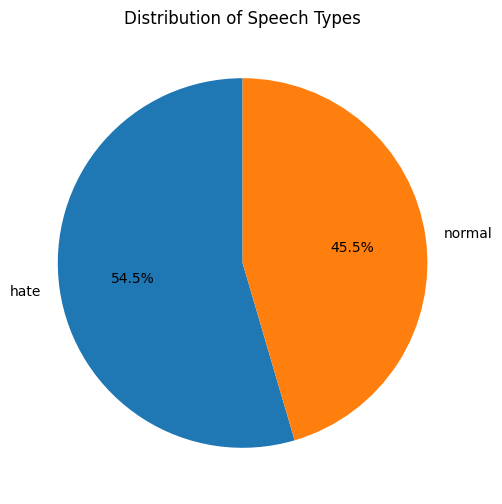

In [ ]:
# @title Distribution of Speech Types

import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = combined_df['Label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Distribution of Speech Types')


In [ ]:
combined_df['Label'] = combined_df['Label'].replace(['normal', 'hate'], ['መልካም', 'ጥላቻ'])

In [ ]:
# Predict
combined_df['Predicted_Label'] = predict_hate_speech(combined_df['Content'], model, tokenizer)

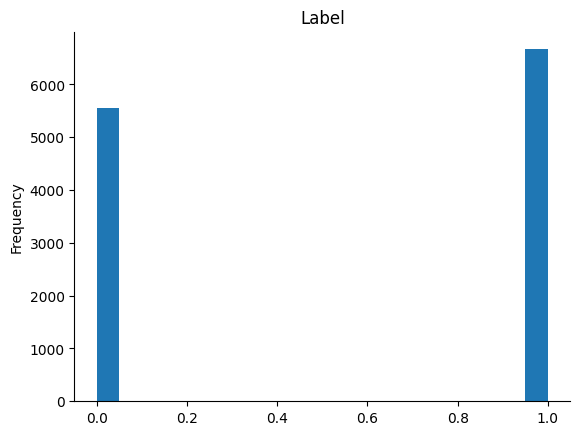

In [ ]:
# @title Label

from matplotlib import pyplot as plt
Merged['Label'].plot(kind='hist', bins=20, title='Label')
plt.gca().spines[['top', 'right',]].set_visible(False)